In [1]:
%reset
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.ticker as mticker
import warnings; warnings.filterwarnings('ignore')
import cmocean

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [103]:
%cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/
run=20 #1/4 degree NeverWorld2 setup
#run=26 #1/8 degree NeverWorld2 setup
#run=28 #1/16 degree NeverWorld2 setup
fs=xr.open_dataset('run%i/static.nc' % (run), decode_times=False)
os=xr.open_dataset('run%i/ocean.stats.nc' % (run), decode_times=False)
forcing=xr.open_dataset('run%i/forcing_00000500.nc' % (run), decode_times=False)
tau = 500*86400
end_time = 30500
start_time = end_time - tau/86400

sn     = xr.open_dataset('run%i/snapshots_000%i.nc' % (run, end_time-500+5), decode_times=False) #snapshot
av     = xr.open_dataset('run%i/averages_000%i.nc' % (run, end_time-500+2), decode_times=False)  #5-day average
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/
#print(av)

/glade/p/univ/unyu0004/neerajab/NeverWorld2
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [3]:
# #For the 1/32 degree run:

# %cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/
# run=33 #1/32 degree NeverWorld setup
# fs=xr.open_dataset('run%i/static.nc' % (run), decode_times=False)
# os=xr.open_dataset('run%i/ocean.stats.nc' % (run), decode_times=False)
# forcing=xr.open_dataset('run%i/forcing_00002000.nc' % (run), decode_times=False)

# av=xr.open_mfdataset(['run33/averages_00001702.nc','run33/averages_00001802.nc', 'run33/averages_00001902.nc', 'run33/averages_00002002.nc', 'run33/averages_00002102.nc'],decode_times=False,combine='by_coords')
## print(av)
# %cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

(100, 15, 560, 240)

In [104]:
#COMPUTE KE AND THEN WEIGH BY THICKNESS
Nlayers=15
lon=fs['geolon']; lat=fs['geolat']
depth = fs['depth_ocean']
xh = fs.xh.values
yh = fs.yh.values

h  = np.nanmean(np.array(av['h'][:,:,:,:]),axis=0);
#Interface = np.array(os['Interface']); drho=np.diff(Interface)
#drhomat=np.transpose(np.tile(drho,[len(yh),len(xh),1]),(2,0,1)); 
#print(drhomat.shape,h.shape)
#drhodz=drhomat/h
#N2=(9.81/1025.)*drhodz; N2[N2>1.e-3] =np.nan; mask=N2*0.0+1.0

print('done 0')
#Outputs are comprised of 100 5-day averages.
u  = np.array(av['u'][:,:,:,:]); u = 0.5*(u[:,:,:,1:]+u[:,:,:,:-1]); u[np.isnan(u)]=0;
ubar=np.nanmean(u,axis=0)
v  = np.array(av['v'][:,:,:,:]); v = 0.5*(v[:,:,1:,:]+v[:,:,:-1,:]); v[np.isnan(v)]=0;
vbar=np.nanmean(v,axis=0)
h[np.isnan(h)]=0.0
uprime=np.zeros(u.shape); vprime=np.zeros(v.shape)
for it in range (0,len(u[:,0,0,0])):
    uprime[it,:,:,:]=u[it,:,:,:]-ubar
    vprime[it,:,:,:]=v[it,:,:,:]-vbar
    #print(it)

print(uprime.shape)


done 0
(100, 15, 560, 240)


In [105]:
np.min(h)

0.0

In [106]:
Depth_3D.shape

(15, 2240, 960)

In [107]:
# #Filtering out places where N2 is large
# u  = u*mask; v  = v*mask; h = h*mask
Depth_3D=np.transpose(np.tile(np.nansum(h,axis=0),[Nlayers,1,1]),(0,1,2))
ubar_TW=ubar*h/Depth_3D; 
ubar_BT=np.tile(np.nansum(ubar_TW,axis=0),[Nlayers,1,1])
ubar_BC=ubar-ubar_BT;

vbar_TW=vbar*h/Depth_3D
vbar_BT=np.tile(np.nansum(vbar_TW,axis=0),[Nlayers,1,1])
vbar_BC=vbar-vbar_BT;

KE_mean_BT=0.5*(vbar_BT[0,:,:]**2+ubar_BT[0,:,:]**2) #dim y,x
KE_mean_BC=np.nansum(0.5*(vbar_BC**2+ubar_BC**2)*h/Depth_3D,axis=0) #dim y,x

#uprime_BT=np.zeros(u.shape); vprime_BT=np.zeros(v.shape)
#uprime_BC=np.zeros(u.shape); vprime_BC=np.zeros(v.shape)
KE_eddy_BT_temp=np.zeros(u[:,0,:,:].shape); 
KE_eddy_BC_temp=np.zeros(u[:,0,:,:].shape)
KE_tot_TESTING=np.zeros(u[:,0,:,:].shape)

for it in range (0,len(u[:,0,0,0])):
    uprime_BT=np.tile(np.nansum(uprime[it,:,:,:]*h/Depth_3D,axis=0),[Nlayers,1,1])
    uprime_BC=uprime[it,:,:,:]-uprime_BT
    vprime_BT=np.tile(np.nansum(vprime[it,:,:,:]*h/Depth_3D,axis=0),[Nlayers,1,1])
    vprime_BC=vprime[it,:,:,:]-vprime_BT
    
    KE_eddy_BT_temp[it,:,:]=0.5*(vprime_BT[0,:,:]**2+uprime_BT[0,:,:]**2)
    KE_eddy_BC_temp[it,:,:]=np.nansum(0.5*(vprime_BC**2+uprime_BC**2)*h/Depth_3D,axis=0)
    KE_tot_TESTING[it,:,:]= np.nansum(0.5*(u[it,:,:,:]**2+v[it,:,:,:]**2)*h/Depth_3D,axis=0)
    #print(it)
    
KE_eddy_BT = np.nanmean(KE_eddy_BT_temp,axis=0)
KE_eddy_BC = np.nanmean(KE_eddy_BC_temp,axis=0)

# #Total kinetic energy:
KE_BT_tot=KE_eddy_BT+KE_mean_BT
KE_BC_tot=KE_eddy_BC+KE_mean_BC
KE_tot=KE_BT_tot+KE_BC_tot
KE_tot_test=np.nanmean(KE_tot_TESTING,axis=0)

print(KE_tot.shape)

(560, 240)


In [108]:
KE_tot_TESTING.shape

(100, 560, 240)

In [109]:
fraction_BT=KE_BT_tot/KE_tot
fraction_BT_mean=KE_mean_BT/KE_tot
fraction_BT_eddy=KE_eddy_BT/KE_tot
fraction_BC=KE_BC_tot/KE_tot #when you divide zero/zero it's a nan
fraction_BC_mean=KE_mean_BC/KE_tot
fraction_BC_eddy=KE_eddy_BC/KE_tot

In [110]:
print('done')

done


Text(0.5, 1.0, '$log_{10}(KE)$')

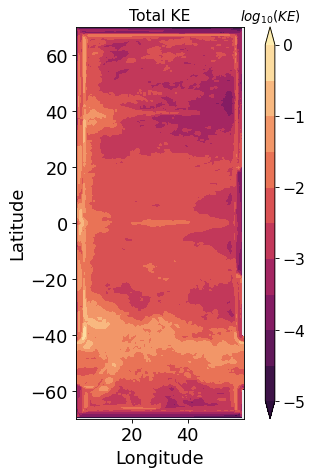

In [89]:
fig = plt.figure(figsize=(4, 7), dpi=80, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Total KE',fontsize=14)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 

plotted =ax1.contourf(xh,yh,np.log10(KE_tot),levels=np.linspace(-5.,0,11),cmap=cmocean.cm.matter_r,extend='both')
ax1.set_aspect('equal', 'box')

ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax2.tick_params(labelsize=14)
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);
ax2.set_title('$log_{10}(KE)$')


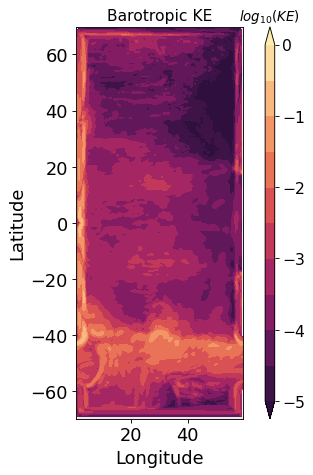

In [56]:
fig = plt.figure(figsize=(4, 7), dpi=80, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Barotropic KE',fontsize=14)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 

plotted =ax1.contourf(xh,yh,np.log10(KE_BT_tot),levels=np.linspace(-5.,0,11),cmap=cmocean.cm.matter_r,extend='both')
ax1.set_aspect('equal', 'box')

ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax2.tick_params(labelsize=14)
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);
ax2.set_title('$log_{10}(KE)$')
#
plt.show()

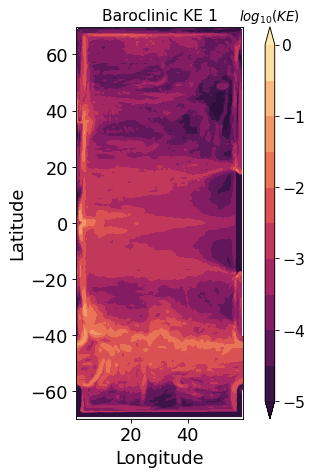

In [58]:
fig = plt.figure(figsize=(4, 7), dpi=80, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Baroclinic KE 1',fontsize=14) #METHOD 1
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 

plotted =ax1.contourf(xh,yh,np.log10(KE_BC_tot),levels=np.linspace(-5.,0,11),cmap=cmocean.cm.matter_r,extend='both')
ax1.set_aspect('equal', 'box')

ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax2.tick_params(labelsize=14)
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);
ax2.set_title('$log_{10}(KE)$')
#
plt.show()

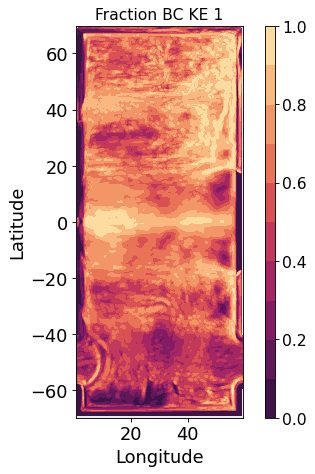

In [59]:
fig = plt.figure(figsize=(4, 7), dpi=80, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Fraction BC KE 1',fontsize=14)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 


plotted =ax1.contourf(xh,yh,fraction_BC,levels=np.linspace(0.,1.,11),cmap=cmocean.cm.matter_r)
ax1.set_aspect('equal', 'box')

ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax2.tick_params(labelsize=14)
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);

#
plt.show()

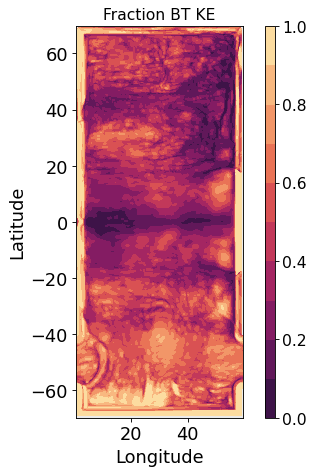

In [60]:
fig = plt.figure(figsize=(4, 7), dpi=80, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Fraction BT KE',fontsize=14)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 

plotted =ax1.contourf(xh,yh,fraction_BT,levels=np.linspace(0.,1.,11),cmap=cmocean.cm.matter_r)
ax1.set_aspect('equal', 'box')

ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax2.tick_params(labelsize=14)
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);

#
plt.show()

Text(0.5, 1.0, '1/4$^\\circ$ KE fractions')

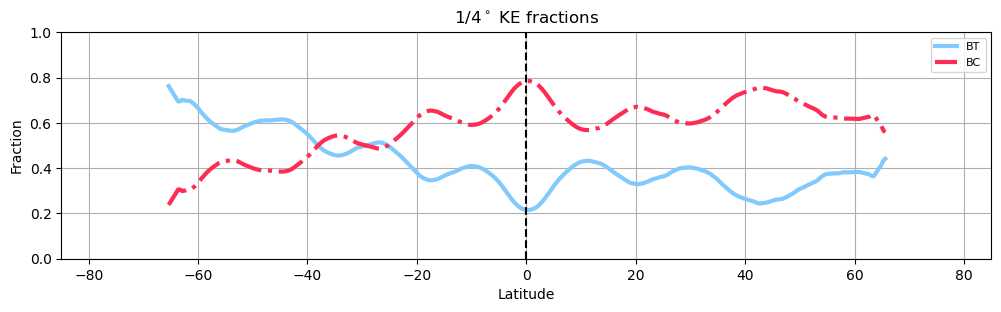

In [62]:
#For the convolution window use N=240 for 1/32 deg.; N=120 for 1/16deg.; N=60 for 1/8deg.; and N=30 for 1/4deg.
window=30

plt.figure(figsize=(12, 3), dpi= 100, facecolor='w', edgecolor='k')
#plt.plot(yh,np.nanmean(fraction_BT,axis=1),'-',c='#82cafc',linewidth=3)
plt.plot(yh,np.convolve(np.nanmean(fraction_BT,axis=1), np.ones((window,))/window, mode='same'),'-',c='#82cafc',linewidth=3)
plt.grid()
plt.plot(yh,np.convolve(np.nanmean(fraction_BC,axis=1), np.ones((window,))/window, mode='same'),'-.',c='#fe2c54',linewidth=3)

plt.legend(['BT','BC'],loc='upper right',fontsize=8)
plt.plot([0, 0],[0, 1],'--',color=[0,0,0])
plt.xlim(-85, 85)
plt.ylim(0,1);
plt.xlabel('Latitude')
plt.ylabel('Fraction')
plt.title('1/4$^\circ$ KE fractions')

Text(0.5, 1.0, '1/4$^\\circ$ KE fractions')

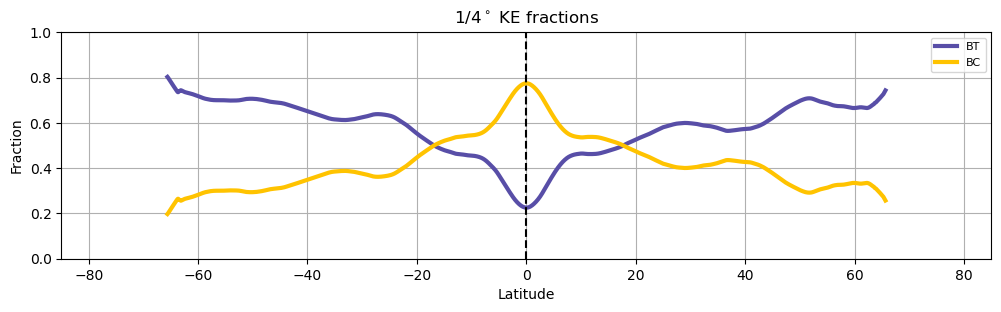

In [94]:
#For the convolution window use N=240 for 1/32 deg.; N=120 for 1/16deg.; N=60 for 1/8deg.; and N=30 for 1/4deg.
window=120

plt.figure(figsize=(12, 3), dpi= 100, facecolor='w', edgecolor='k')
#plt.plot(yh,np.nanmean(fraction_BT,axis=1),'-',c='#82cafc',linewidth=3)
plt.plot(yh,np.convolve(np.nanmean(fraction_BT,axis=1), np.ones((window,))/window, mode='same'),'-',c='#584EA7',linewidth=3)
plt.grid()
plt.plot(yh,np.convolve(np.nanmean(fraction_BC,axis=1), np.ones((window,))/window, mode='same'),'-',c='#FFC300',linewidth=3)

plt.legend(['BT','BC'],loc='upper right',fontsize=8)
plt.plot([0, 0],[0, 1],'--',color=[0,0,0])
plt.xlim(-85, 85)
plt.ylim(0,1);
plt.xlabel('Latitude')
plt.ylabel('Fraction')
plt.title('1/4$^\circ$ KE fractions')

Text(0.5, 1.0, '1/4$^\\circ$ KE fractions')

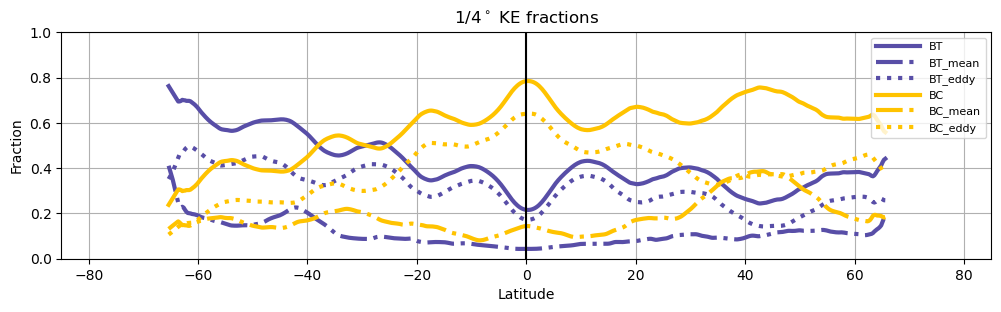

In [111]:
#For the convolution window use N=240 for 1/32 deg.; N=120 for 1/16deg.; N=60 for 1/8deg.; and N=30 for 1/4deg.
window=30

plt.figure(figsize=(12, 3), dpi= 100, facecolor='w', edgecolor='k')
#plt.plot(yh,np.nanmean(fraction_BT,axis=1),'-',c='#82cafc',linewidth=3)
plt.plot(yh,np.convolve(np.nanmean(fraction_BT,axis=1), np.ones((window,))/window, mode='same'),'-',c='#584EA7',linewidth=3)
plt.plot(yh,np.convolve(np.nanmean(fraction_BT_mean,axis=1), np.ones((window,))/window, mode='same'),'-.',c='#584EA7',linewidth=3)
plt.plot(yh,np.convolve(np.nanmean(fraction_BT_eddy,axis=1), np.ones((window,))/window, mode='same'),':',c='#584EA7',linewidth=3)
plt.grid()
plt.plot(yh,np.convolve(np.nanmean(fraction_BC,axis=1), np.ones((window,))/window, mode='same'),'-',c='#FFC300',linewidth=3)
plt.plot(yh,np.convolve(np.nanmean(fraction_BC_mean,axis=1), np.ones((window,))/window, mode='same'),'-.',c='#FFC300',linewidth=3)
plt.plot(yh,np.convolve(np.nanmean(fraction_BC_eddy,axis=1), np.ones((window,))/window, mode='same'),':',c='#FFC300',linewidth=3)
#plt.plot(yh,np.convolve(np.nanmean(fraction_BT_mean+fraction_BT_eddy,axis=1), np.ones((window,))/window, mode='same'),':',c='r',linewidth=3)
#plt.plot(yh,np.convolve(np.nanmean(fraction_BC_mean+fraction_BC_eddy,axis=1), np.ones((window,))/window, mode='same'),':',c='r',linewidth=3)

plt.legend(['BT','BT_mean','BT_eddy','BC','BC_mean','BC_eddy'],loc='upper right',fontsize=8,handlelength=4)
plt.plot([0, 0],[0, 1],'-',color=[0,0,0])
plt.xlim(-85, 85)
plt.ylim(0,1);
plt.xlabel('Latitude')
plt.ylabel('Fraction')
plt.title('1/4$^\circ$ KE fractions')

Text(0.5, 1.0, '1/4$^\\circ$ KE fractions')

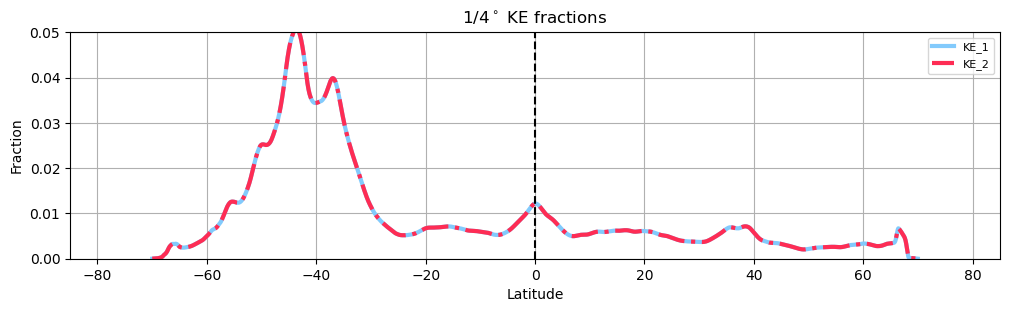

In [93]:
#For the convolution window use N=240 for 1/32 deg.; N=120 for 1/16deg.; N=60 for 1/8deg.; and N=30 for 1/4deg.
window=30

plt.figure(figsize=(12, 3), dpi= 100, facecolor='w', edgecolor='k')
#plt.plot(yh,np.nanmean(fraction_BT,axis=1),'-',c='#82cafc',linewidth=3)
plt.plot(yh,np.convolve(np.nanmean(KE_tot,axis=1), np.ones((window,))/window, mode='same'),'-',c='#82cafc',linewidth=3)
plt.grid()
plt.plot(yh,np.convolve(np.nanmean(KE_tot_test,axis=1), np.ones((window,))/window, mode='same'),'-.',c='#fe2c54',linewidth=3)

plt.legend(['KE_1','KE_2'],loc='upper right',fontsize=8)
plt.plot([0, 0],[0, 1],'--',color=[0,0,0])
plt.xlim(-85, 85)
plt.ylim(0,.05);
plt.xlabel('Latitude')
plt.ylabel('Fraction')
plt.title('1/4$^\circ$ KE fractions')